# Analyzing risk of a stock market portfolio

We will implement the Value at Risk (VaR) and Conditional Value at Risk (CVaR) using:<br>
- Historical method
- Parametric method
- Monte Carlo method

In [9]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr

Now, we write the function to import the data. Our data includes the name of the stock, start date and end date

In [10]:
def get_data(stocks, start, end):
    stock_data = pdr.get_data_yahoo(stocks, start=start, end=end)
    stock_data = stock_data['Close']
    returns = stock_data.pct_change()
    mean_return = returns.mean()
    cov_matrix = returns.cov()
    return returns, mean_return, cov_matrix

From the data from the function above, we calculate the performance of the portfolio

In [11]:
def portfolio_performance(weights, mean_return, cov_matrix, time):
    returns = np.sum(mean_return * weights) * time
    sd = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(time)
    return returns, sd

Now we instantiate our portfolio

In [12]:
stocklist = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stocklist]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=800)

In [13]:
returns, mean_return, cov_matrix = get_data(stocks, start_date, end_date)
returns = returns.dropna()
print(returns)

Symbols       CBA.AX    BHP.AX    TLS.AX    NAB.AX    WBC.AX    STO.AX
Date                                                                  
2019-04-08 -0.003103  0.017083  0.000000 -0.004434 -0.006526  0.022489
2019-04-09 -0.005943  0.003510  0.009174 -0.004453 -0.001546  0.029325
2019-04-10  0.007117 -0.003497 -0.003030  0.001627  0.002322 -0.004274
2019-04-11 -0.006926 -0.006267  0.006079 -0.007714 -0.012741  0.004292
2019-04-12  0.019499 -0.001514  0.006042  0.010229  0.013688  0.001425
...              ...       ...       ...       ...       ...       ...
2021-06-07 -0.005755  0.002051 -0.002793 -0.031625 -0.008932 -0.002591
2021-06-08 -0.004415 -0.009621 -0.002801  0.004880  0.003755  0.005195
2021-06-09 -0.003942  0.005994  0.002809 -0.007845 -0.006734 -0.009044
2021-06-10  0.007618 -0.007602  0.000000  0.002259  0.001507 -0.009126
2021-06-11 -0.004811  0.013458  0.002801 -0.006011 -0.011282  0.009211

[553 rows x 6 columns]


We randomize the weights of the stocks in our portfolio by using np.random

In [14]:
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

Now, we associate the weights for the stocks in our portfolio

In [15]:
returns['portfolio'] = returns.dot(weights)
print(returns)

Symbols       CBA.AX    BHP.AX    TLS.AX    NAB.AX    WBC.AX    STO.AX  \
Date                                                                     
2019-04-08 -0.003103  0.017083  0.000000 -0.004434 -0.006526  0.022489   
2019-04-09 -0.005943  0.003510  0.009174 -0.004453 -0.001546  0.029325   
2019-04-10  0.007117 -0.003497 -0.003030  0.001627  0.002322 -0.004274   
2019-04-11 -0.006926 -0.006267  0.006079 -0.007714 -0.012741  0.004292   
2019-04-12  0.019499 -0.001514  0.006042  0.010229  0.013688  0.001425   
...              ...       ...       ...       ...       ...       ...   
2021-06-07 -0.005755  0.002051 -0.002793 -0.031625 -0.008932 -0.002591   
2021-06-08 -0.004415 -0.009621 -0.002801  0.004880  0.003755  0.005195   
2021-06-09 -0.003942  0.005994  0.002809 -0.007845 -0.006734 -0.009044   
2021-06-10  0.007618 -0.007602  0.000000  0.002259  0.001507 -0.009126   
2021-06-11 -0.004811  0.013458  0.002801 -0.006011 -0.011282  0.009211   

Symbols     portfolio  
Date         

### Historical VaR

The formula for VaR is: <br><br> 
## $$VaR_a(X) = -inf\{x \in \mathbb{R} | F_x (x) > a\} = F_{Y}^{-1} (1 - a)$$

![Image](https://upload.wikimedia.org/wikipedia/commons/6/64/VaR_diagram.JPG)

Some theory:<br>
- If $X$ is a random variable for the Profit and Loss distribution, $Y = -X(loss\ distribution)$
- $F_{x} (x)$ is the CDF of the Profit and Loss distribution, $F_{Y}^{-1} (y)$ is the inverse CDF of loss distribution

Now we write a function to calculate the historical VaR. We want to read the returns dataframe and output the percentile of the distribution at the given alpha confidence interval

In [16]:
def historical_var(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isintance(returns, pd.DataFrame):
        return returns.aggregate(historical_var, alpha=5)
    else:
        raise TypeError

Function to calculate historical cVaR (aka expected short fall):

![Image](https://i.ytimg.com/vi/qML5RpE7mxw/maxresdefault.jpg)

In [17]:
def historical_cvar(returns, alpha=5):
    if isinstance(returns, pd.Series):
        below_var = returns <= historical_var(returns, alpha)
        return returns[below_var].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historical_cvar, alpha=5)
    else:
        raise TypeError

In [18]:
time = 1

var = -historical_var(returns['portfolio'], 5) * np.sqrt(time)
cvar = -historical_cvar(returns['portfolio'], 5) * np.sqrt(time)
returns, sd = portfolio_performance(weights, mean_return, cov_matrix, time)

initial_investment = 100000
print('Expected portfolio return: ', round(initial_investment * returns, 2))
print('Value at risk at 95% confidence interval: ', round(initial_investment * var, 2))
print('Conditional value at risk at 95% confidence interval: ', round(initial_investment * cvar, 2))

Expected portfolio return:  52.2
Value at risk at 95% confidence interval:  2319.71
Conditional value at risk at 95% confidence interval:  4122.53


### Parametric VaR

<b>t-distribution formulas:</b><br>
## $$t VaR_{\nu, \alpha, h} = \sqrt{\nu^{-1}(\nu - 2)}t_{\nu}^{-1}(1 - \alpha)\sigma_h - \mu_h$$<br>

## $$t CVar_{\nu, \alpha, h} = -\alpha^{-1}(1 - \nu)^{-1}(\nu - 2 + x_{\alpha, \nu}^2)f_{\nu}(x_{\alpha, \nu})\sigma_{h} - \mu_h$$

<b>Normal distribution</b><br>
## $$CVar_{\alpha, h}(X) = \alpha^{-1}\phi(\Phi^{-1}(\alpha))\sigma_h - \mu_h$$
$\phi(z)$: standard normal density function<br>
$\Phi^{-1}(\alpha)$: $\alpha$ quantile of the standard normal distribution

In [29]:
from scipy.stats import norm, t

In [30]:
# https://quantatrisk.com/2015/12/02/student-t-distributed-linear-value-at-risk/
def parametric_var(portfolio_return, portfolio_std, distribution='normal', alpha=5, dof=6):
    """
    Calculate the portfolio VaR given a distribution, with known parameters
    """
    if distribution == 'normal':
        var = norm.ppf(1 - alpha / 100) * portfolio_std - portfolio_return
    elif distribution == 't-distribution':
        nu = dof
        var = np.sqrt((nu - 2) / nu) * t.ppf(1 - alpha / 100, nu) * portfolio_std - portfolio_return
    else:
        raise TypeError('Expected to be normal or t-distribution')
    return var

In [31]:
def parametric_cvar(portfolio_return, portfolio_std, distribution='normal', alpha=5, dof=6):
    """
    Calculate the portfolio CVaR given a distribution, with known parameters
    """
    if distribution == 'normal':
        cvar = (alpha / 100) ** -1 * norm.pdf(norm.ppf(alpha / 100)) * portfolio_std - portfolio_return
    elif distribution == 't-distribution':
        nu = dof
        #calculate x_{a, \nu}
        x_anu = t.ppf(alpha / 100, nu)
        cvar = -1 / (alpha / 100) * (1 - nu) ** -1 * (nu - 2 + x_anu ** 2) * t.pdf(x_anu, nu) * portfolio_std - portfolio_return
    else:
        raise TypeError('Expected to be normal or t-distribution')
    return cvar

In [32]:
normal_var = parametric_var(returns, sd, distribution='normal')
normal_cvar = parametric_cvar(returns, sd, distribution='normal')

t_var = parametric_var(returns, sd, distribution='t-distribution')
t_cvar = parametric_cvar(returns, sd, distribution='t-distribution')

print('Normal value at risk at 95% confidence interval: ', round(initial_investment * normal_var, 2))
print('t-distribution value at risk at 95% confidence interval: ', round(initial_investment * t_var, 2))

print('Normal conditional value at risk at 95% confidence interval: ', round(initial_investment * normal_cvar, 2))
print('t-distribution conditional value at risk at 95% confidence interval: ', round(initial_investment * t_cvar, 2))

Normal value at risk at 95% confidence interval:  2743.04
t-distribution value at risk at 95% confidence interval:  2644.05
Normal conditional value at risk at 95% confidence interval:  3453.15
t-distribution conditional value at risk at 95% confidence interval:  3611.96


### Monte Carlo value at risk

The following function receives input as a pandas series of returns and output the percentile on return distribution to a given confidence interval $\alpha$

In [41]:
def mc_var(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

In [42]:
def mc_cvar(returns, alpha=5):
    if isinstance(returns, pd.Series):
        below_var = returns <= mc_var(returns, alpha=alpha)
        return returns[below_var].mean()
    else:
        raise TypeError("Expected a pandas data series.")

Next we create the Monte Carlo method to simulate the portfolio over time

In [43]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
time = 100 #timeframe in days

mean_matrix = np.full(shape=(time, len(weights)), fill_value=mean_return)
mean_matrix = mean_matrix.T

portfolio_sims = np.full(shape=(time, mc_sims), fill_value=0.0)

initial_portfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(time, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T) + 1) * initial_portfolio

Plot the simulation

In [44]:
import matplotlib.pyplot as plt

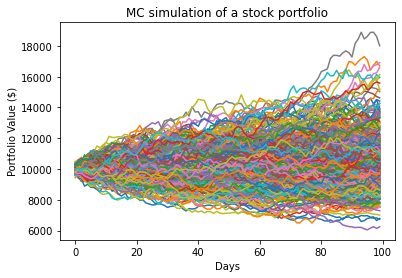

In [45]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

Print the Monte Carlo var function result:

In [46]:
results = pd.Series(portfolio_sims[-1,:])

var = initial_portfolio - mc_var(results, alpha=5)
cvar = initial_portfolio - mc_cvar(results, alpha=5)

print('Value at Risk ${}'.format(round(var, 2)))
print('Conditional Value at Risk ${}'.format(round(cvar, 2)))

Value at Risk $1999.17
Conditional Value at Risk $2543.54
